In [1]:
import sys
sys.path.append("/home/bgreene/SBL_LES/python/")
import yaml
import numpy as np
import xarray as xr
import seaborn
from cmocean import cm
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from LESnc import load_stats
from RFMnc import recalc_err

In [2]:
# plotting setup
rc('font',weight='normal',size=20,family='serif',serif='Times New Roman')
rc('text',usetex='True')
props=dict(boxstyle="square",facecolor="white",edgecolor="white",alpha=0.0)
props2=dict(boxstyle='square',facecolor='white',alpha=0.85)

# Load Data

In [14]:
# load yaml file
with open("/home/bgreene/SBL_LES/python/RFMnc.yaml") as f:
    config = yaml.safe_load(f)
# directories
# figure save
figdir = "/home/bgreene/SBL_LES/figures/RFMnc/"
# list of simulations to loop over
# sims = ["cr0.10_u08", "cr0.25_u08", "cr0.33_u08", "cr0.50_u08",
#         "cr1.00_u08", "cr1.50_u08"]#, "cr2.00_u08", "cr2.50_u08"]
sims = ["cr0.25_u08", "cr0.50_u08", "cr1.00_u08", 
        "cr1.50_u08", "cr2.00_u08", "cr2.50_u08"]
# dictionary of conversions from old label convention (A-F)
labels = {"cr0.25_u08_192": "A",
          "cr0.50_u08_192": "B",
          "cr1.00_u08_192": "C",
          "cr1.50_u08_192": "D",
          "cr2.00_u08_192": "E",
          "cr2.50_u08_192": "F"}
# empty list to construct paths and store
dnc_all = []
sall = []
Lall = []
Aall = []
err = []
# loop over sims and load stats, spectrogram data
for sim in sims:
    dnc = f"/home/bgreene/simulations/{sim}_192/output/netcdf/"
    dnc_all.append(dnc)
    # load stats file
    s = load_stats(dnc+"average_statistics.nc")
    # add labels from convention for JAS paper (A-F)
    if s.stability in labels.keys():
        s.attrs["label2"] = labels[s.stability]
    else:
        s.attrs["label2"] = s.label
    sall.append(s)
    # load integral lengthscales
    l = xr.load_dataset(dnc+"L.nc")
    Lall.append(l)
    # load autocorr files
    a = xr.load_dataset(dnc+"autocorr.nc")
    Aall.append(a)
    # load error files
    e = xr.load_dataset(dnc+"err.nc")
    err.append(e)
    
# define colormap based on number of simulations
nsim = len(sims)
cmap = seaborn.color_palette("cubehelix_r", nsim)
colors = seaborn.color_palette("crest", nsim)

Reading file: /home/bgreene/simulations/cr0.25_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.50_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr1.00_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr1.50_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr2.00_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr2.50_u08_192/output/netcdf/average_statistics.nc


# Plot Integral Lengthscales

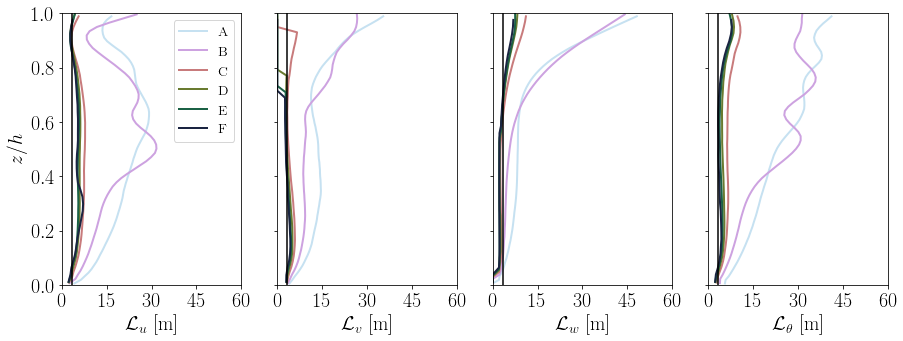

In [15]:
# four panel: u, v, w, theta
fig1, ax1 = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(14.8, 5))
for i, (l, s) in enumerate(zip(Lall, sall)):
    # u
    ax1[0].plot(l.u_rot, l.z/s.h, ls="-", lw=2, c=cmap[i], label=s.label2)
    # v
    ax1[1].plot(l.v_rot, l.z/s.h, ls="-", lw=2, c=cmap[i])
    # w
    ax1[2].plot(l.w, l.z/s.h, ls="-", lw=2, c=cmap[i])
    # theta
    ax1[3].plot(l.theta, l.z/s.h, ls="-", lw=2, c=cmap[i])
# labels
ax1[0].legend(fontsize=14)
ax1[0].set_ylim([0, 1])
ax1[0].set_ylabel("$z/h$")
ax1[0].set_xlim([0, 60])
ax1[0].xaxis.set_major_locator(MultipleLocator(15))
ax1[0].set_xlabel("$\\mathcal{L}_u$ [m]")

ax1[1].set_xlim([0, 60])
ax1[1].xaxis.set_major_locator(MultipleLocator(15))
ax1[1].set_xlabel("$\\mathcal{L}_v$ [m]")

ax1[2].set_xlim([0, 60])
ax1[2].xaxis.set_major_locator(MultipleLocator(15))
ax1[2].set_xlabel("$\\mathcal{L}_w$ [m]")

ax1[3].set_xlim([0, 60])
ax1[3].xaxis.set_major_locator(MultipleLocator(15))
ax1[3].set_xlabel("$\\mathcal{L}_{\\theta}$ [m]")

# vertical line for LES resolution
for iax in ax1:
    iax.axvline(sall[0].delta, color="k")

In [16]:
s = sall[-1]
s.h / 2

<xarray.DataArray 'h' ()>
array(40.22859833)

5.376832900651987


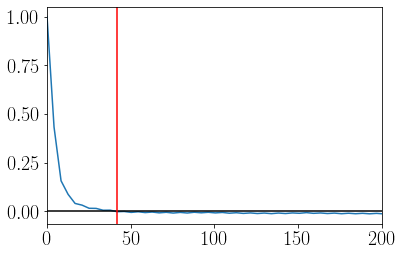

In [17]:
# plot autocorrelations
R = Aall[-1]
Ru = R.u_rot.sel(z=45, method="nearest")

fig1a, ax1a = plt.subplots(1)
ax1a.plot(R.x, Ru)
ax1a.set_xlim([0, 200])
ax1a.axhline(0, c="k")

izero = np.where(Ru < 0.)[0][0]
print(Ru.isel(x=range(izero)).integrate("x").values)
ax1a.axvline(Ru.x[izero], color="r")

Text(0.5, 0, '$\\mathcal{L}_{\\sigma_{\\theta}^2}$ [m]')

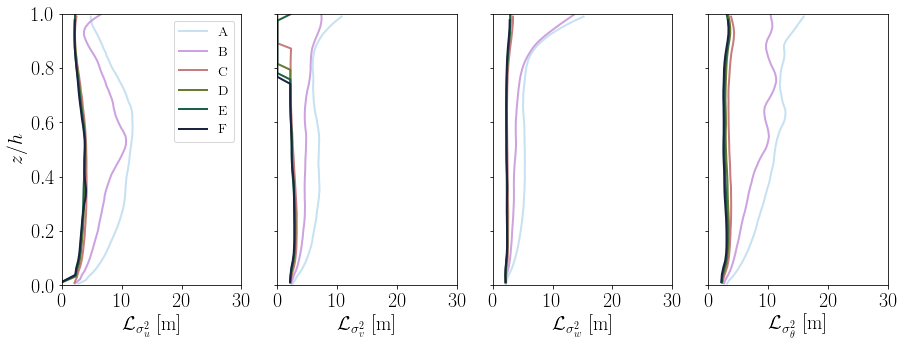

In [18]:
# four panel: u, v, w, theta variances
fig2, ax2 = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(14.8, 5))
for i, (l, s) in enumerate(zip(Lall, sall)):
    # u
    ax2[0].plot(l.uu_var_rot, l.z/s.h, ls="-", lw=2, c=cmap[i], label=s.label2)
    # v
    ax2[1].plot(l.vv_var_rot, l.z/s.h, ls="-", lw=2, c=cmap[i])
    # w
    ax2[2].plot(l.ww_var, l.z/s.h, ls="-", lw=2, c=cmap[i])
    # theta
    ax2[3].plot(l.tt_var, l.z/s.h, ls="-", lw=2, c=cmap[i])
# labels
ax2[0].legend(fontsize=14)
ax2[0].set_ylim([0, 1])
ax2[0].set_ylabel("$z/h$")
ax2[0].set_xlim([0, 30])
ax2[0].xaxis.set_major_locator(MultipleLocator(10))
ax2[0].set_xlabel("$\\mathcal{L}_{\\sigma_u^2}$ [m]")

ax2[1].set_xlim([0, 30])
ax2[1].xaxis.set_major_locator(MultipleLocator(10))
ax2[1].set_xlabel("$\\mathcal{L}_{\\sigma_v^2}$ [m]")

ax2[2].set_xlim([0, 30])
ax2[2].xaxis.set_major_locator(MultipleLocator(10))
ax2[2].set_xlabel("$\\mathcal{L}_{\\sigma_w^2}$ [m]")

ax2[3].set_xlim([0, 30])
ax2[3].xaxis.set_major_locator(MultipleLocator(10))
ax2[3].set_xlabel("$\\mathcal{L}_{\\sigma_{\\theta}^2}$ [m]")

Text(0.5, 0, "$\\mathcal{L}_{\\overline{\\theta'w'}}$ [m]")

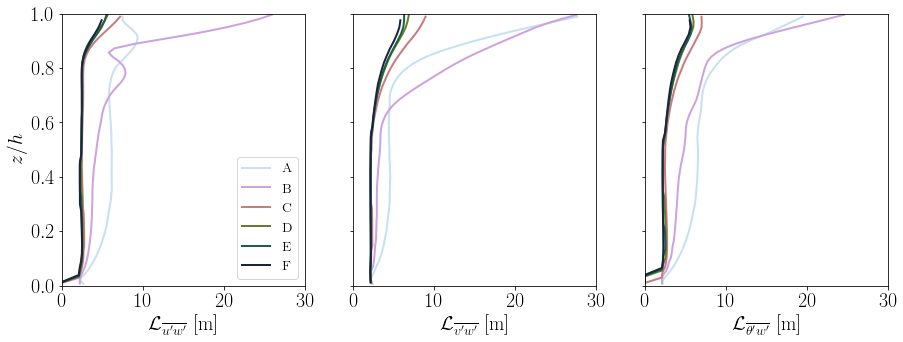

In [19]:
# three panel: uw, vw, tw covariances
fig3, ax3 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14.8, 5))
for i, (l, s) in enumerate(zip(Lall, sall)):
    # uw
    ax3[0].plot(l.uw_cov_tot, l.z/s.h, ls="-", lw=2, c=cmap[i], label=s.label2)
    # vw
    ax3[1].plot(l.vw_cov_tot, l.z/s.h, ls="-", lw=2, c=cmap[i])
    # tw
    ax3[2].plot(l.tw_cov_tot, l.z/s.h, ls="-", lw=2, c=cmap[i])
# labels
ax3[0].legend(fontsize=14)
ax3[0].set_ylim([0, 1])
ax3[0].set_ylabel("$z/h$")
ax3[0].set_xlim([0, 30])
ax3[0].xaxis.set_major_locator(MultipleLocator(10))
ax3[0].set_xlabel("$\\mathcal{L}_{\\overline{u'w'}}$ [m]")

ax3[1].set_xlim([0, 30])
ax3[1].xaxis.set_major_locator(MultipleLocator(10))
ax3[1].set_xlabel("$\\mathcal{L}_{\\overline{v'w'}}$ [m]")

ax3[2].set_xlim([0, 30])
ax3[2].xaxis.set_major_locator(MultipleLocator(10))
ax3[2].set_xlabel("$\\mathcal{L}_{\\overline{\\theta'w'}}$ [m]")

# Plot Error Profiles

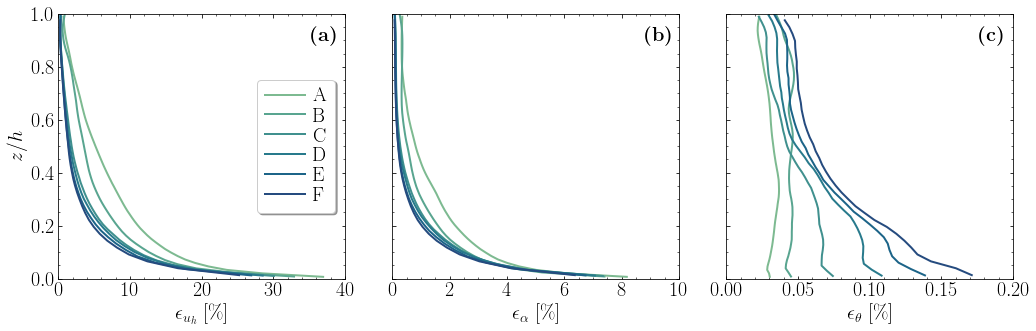

In [20]:
# Figure 1: 3-panel 1st order moments
# wind speed, wind direction, potential temperature
fig1, ax1 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14.8, 5))
# loop through simulations
for i, (e, s) in enumerate(zip(err, sall)):
    # uh
    ax1[0].plot(100.*e.uh, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # alpha
    ax1[1].plot(100.*e.alpha, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # theta
    ax1[2].plot(100.*e.theta, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
# labels
ax1[0].set_xlabel("$\\epsilon_{u_h}$ [\%]")
ax1[0].set_ylabel("$z/h$")
ax1[0].set_xlim([0, 40])
ax1[0].xaxis.set_major_locator(MultipleLocator(10))
ax1[0].xaxis.set_minor_locator(MultipleLocator(2))
ax1[0].set_ylim([0, 1])
ax1[0].yaxis.set_major_locator(MultipleLocator(0.2))
ax1[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax1[0].legend(loc="right", labelspacing=0.10, handletextpad=0.4, shadow=True)
ax1[1].set_xlabel("$\\epsilon_{\\alpha}$ [\%]")
ax1[1].set_xlim([0, 10])
ax1[1].xaxis.set_major_locator(MultipleLocator(2))
ax1[1].xaxis.set_minor_locator(MultipleLocator(0.5))
ax1[2].set_xlabel("$\\epsilon_{\\theta}$ [\%]")
ax1[2].set_xlim([0, 0.2])
ax1[2].xaxis.set_major_locator(MultipleLocator(0.05))
ax1[2].xaxis.set_minor_locator(MultipleLocator(0.01))
# edit ticks and add subplot labels
for iax, s in zip(ax1, list("abc")):
    iax.tick_params(which="both", direction="in", top=True, right=True)
    iax.text(0.88,0.90,f"$\\textbf{{({s})}}$",fontsize=20,
                transform=iax.transAxes)
fig1.tight_layout()
# save and close
# fsave1 = f"{figdir}errors/uh_alpha_theta.pdf"
# print(f"Saving figure: {fsave1}")
# fig1.savefig(fsave1)
# plt.close(fig1)

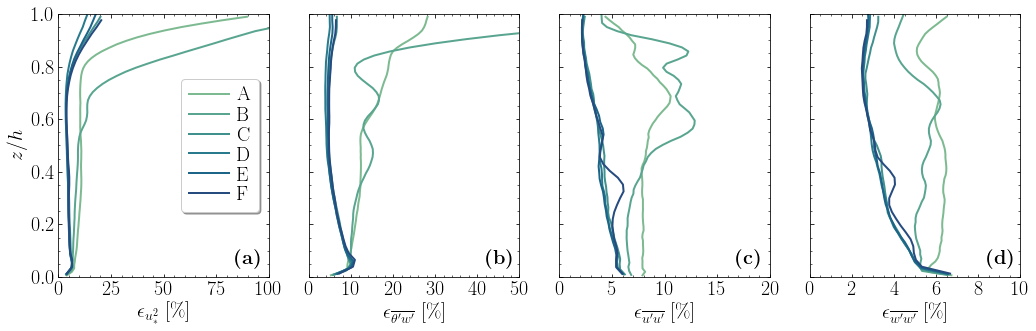

In [21]:
# Figure 2: 4-panel covariances and variances
# ustar2, theta'w', u'u', w'w'
fig2, ax2 = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(14.8, 5))
# loop through simulations
for i, (e, s) in enumerate(zip(err, sall)):
    # u'w'
    ax2[0].plot(100.*e.ustar2, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # theta'w'
    ax2[1].plot(100.*e.tw_cov_tot, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # u'u' rotated
    ax2[2].plot(100.*e.uu_var_rot, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
    # w'w'
    ax2[3].plot(100.*e.ww_var, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
# labels
ax2[0].set_ylabel("$z/h$")
ax2[0].set_ylim([0, 1])
ax2[0].yaxis.set_major_locator(MultipleLocator(0.2))
ax2[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax2[0].set_xlabel("$\\epsilon_{u_{*}^2}$ [\%]")
ax2[0].set_xlim([0, 100])
ax2[0].xaxis.set_major_locator(MultipleLocator(25))
ax2[0].xaxis.set_minor_locator(MultipleLocator(5))
ax2[0].legend(loc="right", labelspacing=0.10, handletextpad=0.4, shadow=True)
ax2[1].set_xlabel("$\\epsilon_{\\overline{\\theta'w'}}$ [\%]")
ax2[1].set_xlim([0, 50])
ax2[1].xaxis.set_major_locator(MultipleLocator(10))
ax2[1].xaxis.set_minor_locator(MultipleLocator(2))
ax2[2].set_xlabel("$\\epsilon_{\\overline{u'u'}}$ [\%]")
ax2[2].set_xlim([0, 20])
ax2[2].xaxis.set_major_locator(MultipleLocator(5))
ax2[2].xaxis.set_minor_locator(MultipleLocator(1))
ax2[3].set_xlabel("$\\epsilon_{\\overline{w'w'}}$ [\%]")
ax2[3].set_xlim([0, 10])
ax2[3].xaxis.set_major_locator(MultipleLocator(2))
ax2[3].xaxis.set_minor_locator(MultipleLocator(0.5))
# edit ticks and add subplot labels
for iax, s in zip(ax2, list("abcd")):
    iax.tick_params(which="both", direction="in", top=True, right=True)
    iax.text(0.84,0.05,f"$\\textbf{{({s})}}$",fontsize=20,
                transform=iax.transAxes)
fig2.tight_layout()
# save and close
# fsave2 = f"{figdir}errors/second_order_all.pdf"
# print(f"Saving figure: {fsave2}")
# fig2.savefig(fsave2)
# plt.close(fig2)

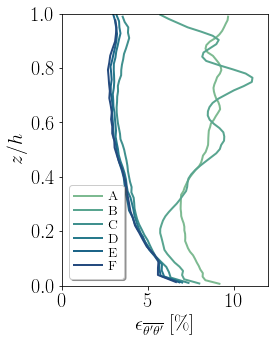

In [22]:
fig2a, ax2a = plt.subplots(1, figsize=(3.7, 5))
for i, (e, s) in enumerate(zip(err, sall)):
    ax2a.plot(100*e.tt_var, e.z/s.h, c=colors[i], ls="-", lw=2, label=s.label2)
# labels
ax2a.set_ylim([0, 1])
ax2a.set_ylabel("$z/h$")
ax2a.set_xlim([0, 12])
ax2a.set_xlabel("$\\epsilon_{\\overline{\\theta'\\theta'}}$ [\%]")
ax2a.legend(fontsize=14, labelspacing=0.10, handletextpad=0.4, shadow=True)

# Plot 2d Error

In [26]:
# construct Tnew from config file
Tnew0 = config["recalc_lo"]
Tnew1 = config["recalc_hi"]
Tnewdt = config["recalc_dt"]
Tnew = np.arange(Tnew0, Tnew1, Tnewdt, dtype=np.float64)
#
# plot one six-panel figure for A & F, uh, alpha, theta
#
# first recalc errors
Aerr = recalc_err("cr0.25_u08_192", Tnew)
Ferr = recalc_err("cr2.50_u08_192", Tnew)

Reading file: /home/bgreene/simulations/cr0.25_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr2.50_u08_192/output/netcdf/average_statistics.nc


Text(0.5, 0, '$\\epsilon_{\\theta}$ [$\\%$]')

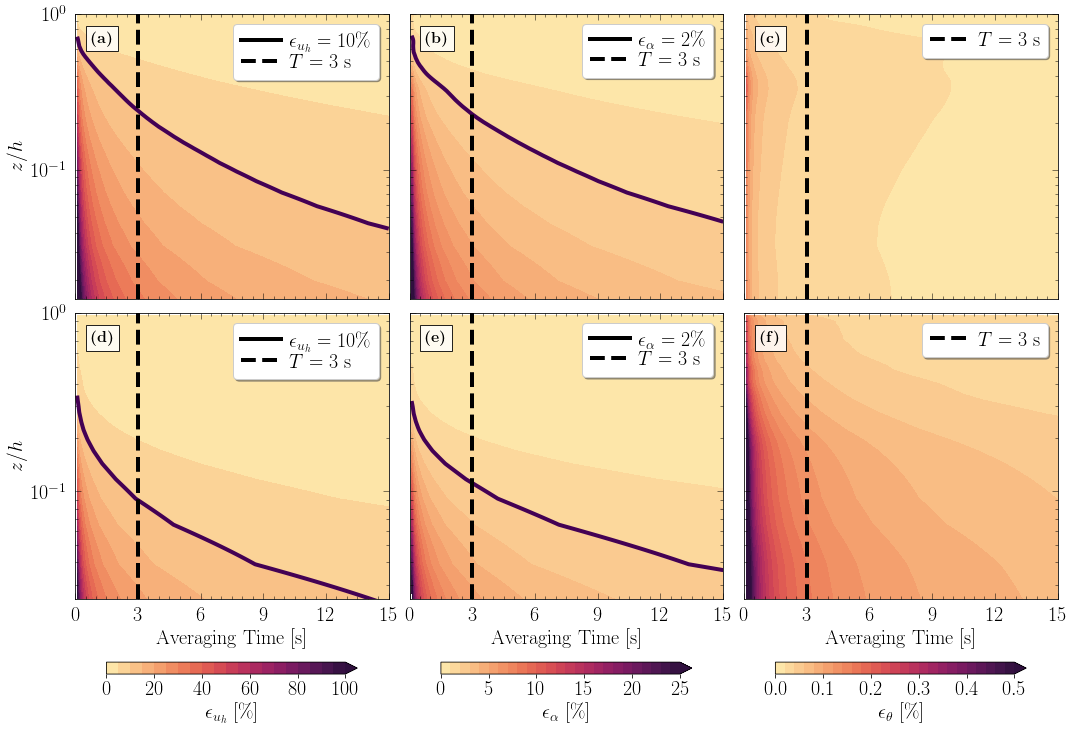

In [27]:
# plot
# figure 1: rows=A, F; columns=uh, alpha, theta
fig3, ax3 = plt.subplots(nrows=2, ncols=3, sharex=True, sharey="row", 
                         constrained_layout=True, figsize=(14.8, 10))
# uh
# A
cfax00 = ax3[0,0].contourf(Aerr.Tsample, Aerr.z/Aerr.h, 100*Aerr.uh,
                            cmap=cm.matter, extend="max",
                            levels=np.linspace(0, 100, 21))
# plot blue line outside of window to use in legend
ax3[0,0].axhline(-10, ls="-", lw=4, c="k", label="$\\epsilon_{u_h}=10\%$")
# F
cfax10 = ax3[1,0].contourf(Ferr.Tsample, Ferr.z/Ferr.h, 100*Ferr.uh,
                            cmap=cm.matter, extend="max",
                            levels=np.linspace(0, 100, 21))
# plot blue line outside of window to use in legend
ax3[1,0].axhline(-10, ls="-", lw=4, c="k", label="$\\epsilon_{u_h}=10\%$")
# contour 10% level
cax00 = ax3[0,0].contour(Aerr.Tsample, Aerr.z/Aerr.h, 100.*Aerr.uh,
                        "-k", levels=[10.], linewidths=4.)
cax10 = ax3[1,0].contour(Ferr.Tsample, Ferr.z/Ferr.h, 100.*Ferr.uh,
                        "-k", levels=[10.], linewidths=4.)
# # alpha
# A
cfax01 = ax3[0,1].contourf(Aerr.Tsample, Aerr.z/Aerr.h, 100*Aerr.alpha,
                            cmap=cm.matter, extend="max",
                            levels=np.linspace(0, 25, 26))
# plot blue line outside of window to use in legend
ax3[0,1].axhline(-10, ls="-", lw=4, c="k", label="$\\epsilon_{\\alpha}=2\%$")
# F
cfax11 = ax3[1,1].contourf(Ferr.Tsample, Ferr.z/Ferr.h, 100*Ferr.alpha,
                            cmap=cm.matter, extend="max",
                            levels=np.linspace(0, 25, 26))
# plot blue line outside of window to use in legend
ax3[1,1].axhline(-10, ls="-", lw=4, c="k", label="$\\epsilon_{\\alpha}=2\%$")
# contour 2% level
cax01 = ax3[0,1].contour(Aerr.Tsample, Aerr.z/Aerr.h, 100.*Aerr.alpha,
                        "-k", levels=[2.], linewidths=4.)
cax11 = ax3[1,1].contour(Ferr.Tsample, Ferr.z/Ferr.h, 100.*Ferr.alpha,
                        "-k", levels=[2.], linewidths=4.)
# theta
# A
cfax02 = ax3[0,2].contourf(Aerr.Tsample, Aerr.z/Aerr.h, 100*Aerr.theta,
                            cmap=cm.matter, extend="max",
                            levels=np.linspace(0, 0.5, 26))
# F
cfax12 = ax3[1,2].contourf(Ferr.Tsample, Ferr.z/Ferr.h, 100*Ferr.theta,
                            cmap=cm.matter, extend="max",
                            levels=np.linspace(0, 0.5, 26))
# plot vertical dashed lines on each panel
for iax, p in zip(ax3.flatten(), list("abcdef")):
    # plot vertical dashed line at T = 3 s
    iax.axvline(3., ls="--", lw=4, c="k", label="$T = 3$ s")
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)
    iax.tick_params(which="major", length=6, width=0.5)
    iax.tick_params(which="minor", length=3, width=0.5)
    iax.text(0.05,0.90,f"$\\textbf{{({p})}}$",fontsize=16,bbox=props2,
                transform=iax.transAxes)
    iax.legend(loc="upper right", labelspacing=0.10, 
                handletextpad=0.4, shadow=True)
# labels
# ax00
ax3[0,0].set_ylabel("$z/h$")
ax3[0,0].set_ylim([0.015, 1])
ax3[0,0].set_yscale("log")
ax3[0,0].set_xlim([0, Tnew1-Tnewdt])
ax3[0,0].xaxis.set_major_locator(MultipleLocator(3))
ax3[0,0].xaxis.set_minor_locator(MultipleLocator(0.5))
# ax01 - none
# ax02 - none
# ax10
ax3[1,0].set_ylabel("$z/h$")
ax3[1,0].set_ylim([0.025, 1])
ax3[1,0].set_yscale("log")
ax3[1,0].set_xlabel("Averaging Time [s]")
# ax11
ax3[1,1].set_xlabel("Averaging Time [s]")
# ax12
ax3[1,2].set_xlabel("Averaging Time [s]")
# colorbars
# col 1: uh
cb1 = fig3.colorbar(cfax00, ax=ax3[:,0], location="bottom", shrink=0.8, 
                    ticks=MultipleLocator(20), pad=0.02)
cb1.ax.set_xlabel("$\\epsilon_{u_h}$ [$\%$]")
# col 2: alpha
cb2 = fig3.colorbar(cfax01, ax=ax3[:,1], location="bottom", shrink=0.8, 
                    ticks=MultipleLocator(5), pad=0.02)
cb2.ax.set_xlabel("$\\epsilon_{\\alpha}$ [$\%$]")
# col 3: theta
cb3 = fig3.colorbar(cfax02, ax=ax3[:,2], location="bottom", shrink=0.8, 
                    ticks=MultipleLocator(0.1), pad=0.02)
cb3.ax.set_xlabel("$\\epsilon_{\\theta}$ [$\%$]")
# save and close
# fsave = f"{figdir}errors2d/AF_uh_alpha_theta.pdf"
# print(f"Saving figure: {fsave}")
# fig.savefig(fsave, format="pdf")
# plt.close(fig)